In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore') #filter some warning messages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Observations from OOI platforms

In [2]:
# site locations
ooi_co =np.array([[47.1336, -124.272,29], # inshore: lat, lon, depth (surface always 7m)
     [46.9859, -124.566, 88], # shelf
     [46.8508, -124.972, 540]]) # offshore
locs = ['Inshore','Shelf','Offshore']

In [19]:
# data directory
ooidir = '~/Documents/LargeData/QIN/OOI_Mooring/'
glodir = '~/Documents/Largedata/QIN/Glorys_Model/'
# figure directory
figdir = '/Users/sol/Google Drive/professional/research/projects/2020_QIN/figures/Comparison_Obs_Glorys/'

In [8]:
# read OOI data and calculate anomalies
ooi_clim = np.full((3,2,3,12,3),np.nan) # 3 sites, 2 depth [surf,bottom], 3 variables [T,S,DO], 12 months, [mean, max, min]

for i in range(len(locs)):
    fn = ooidir+'QIN_'+locs[i]+'_TSDOS.csv'
    tmp = pd.read_csv(fn, index_col=0)
    hd = list(tmp)[2:]
    for j in hd:
        for k in range(12):
            tmp2 = tmp[tmp.Month==k+1][j].values
            if 'T' in j:
                v=0
            elif 'S' in j:
                v=1
            elif 'DO' in j:
                v=2
            if '7' in j:
                d=0
            else:
                d=1
            ooi_clim[i,d,v,k,0] = np.nanmean(tmp2) # mean
            ooi_clim[i,d,v,k,1] = np.nanmax(tmp2) # max
            ooi_clim[i,d,v,k,2] = np.nanmin(tmp2) # min
                 

# Observations from WOA - climatology

In [9]:
woa = pd.read_csv(ooidir+'QIN_WOA_T-DO-S_climatology.csv', index_col=0)
print(list(woa))

WOA_T1 = [46.875,-124.875,150]
WOA_T2 = [47.375,-124.625,100]
WOA_T3 = [46.375,-124.375,70]

WOA_S1 = [46.875,-124.875,150]
WOA_S2 = [47.125,-124.625,55]
WOA_S3 = [46.375,-124.375,100]
WOA_S4 = [46.875,-124.375,60]

WOA_O1 = [46.5,-124.5,125]
WOA_O2 = [47.5,-124.5,25] # changed to 25m... 100 makes no sense... either coords wrong or depth

['Month', 'DO_46.5N,124.5W_Surface', 'DO_46.5N,124.5W_Bottom_125m', 'DO_47.5N,124.5W_Surface', 'DO_47.5N,124.5W_Bottom_100m', 'T_46.875N,124.875W_Surface', 'T_46.875N,124.875W_Bottom_150m', 'T_47.375N,124.625W_Surface', 'T_47.375N,124.625W_Bottom_100m', 'T_46.375N,124.375W_Surface', 'T_46.375N,124.375W_Bottom_70m', 'S_46.875N,124.875W_Surface', 'S_46.875N,124.875W_Bottom_150m', 'S_47.125N,124.625W_Surface', 'S_47.125N,124.625W_Bottom_55m', 'S_46.375N,124.375W_Surface', 'S_46.375N,124.375W_Bottom_100m', 'S_46.875N,124.375W_Surface', 'S_46.875N,124.375W_Bottom_60m']


In [10]:
# modeled climatology data
dsal = xr.open_dataset(glodir+'climatology_glorys12v1_so_v1.nc')
dsal.close()
dsal.coords['lon'] = np.mod(dsal.coords['lon'] + 180,360) - 180
dsal = dsal.sortby(dsal.lon)

dtem = xr.open_dataset(glodir+'climatology_glorys12v1_thetao_v1.nc')
dtem.close()
dtem.coords['lon'] = np.mod(dtem.coords['lon'] + 180,360) - 180
dtem = dtem.sortby(dtem.lon)

dox = xr.open_dataset(glodir+'climatology_glorys12v1_o2_v1.nc')
dox.close()
dox.coords['lon'] = np.mod(dox.coords['lon'] + 180,360) - 180
dox = dox.sortby(dox.lon)

#dtem

In [11]:
# select model data from OOI observations
#ooi_co =[[47.1336, -124.272,29], # inshore: lat, lon, depth (surface always 7m)
#     [46.9859, -124.566, 88], # shelf
#     [46.8508, -124.972, 540]] # offshore

mod_ooi_clim = np.full((3,2,3,12),np.nan) # 3 sites, 2 depth [surf,bottom], 3 variables [T,S,DO], 12 months

# select comparable points

for i in range(3): # variables
    if i==0: #T
        tmp = dtem.thetao
    elif i==1: # sal
        tmp = dsal.so
    else: # DO
        tmp = dox.o2 

    for j in range(len(locs)): # inshore, shelf, offshore
        for k in range(2):  # depth
            if k==0: # surface
                di, df = 6,8
            else:
                di = ooi_co[j,2]-10
                df = ooi_co[j,2]+10
            for km in range(12):
                tmp2 = tmp.sel(time=km+1,depth=slice(di,df),lat=slice(ooi_co[j,0]-0.2,ooi_co[j,0]+0.2), lon=slice(ooi_co[j,1]-0.2,ooi_co[j,1]+0.2))
                mod_ooi_clim[j,k,i,km] = np.nanmean(tmp2)
            

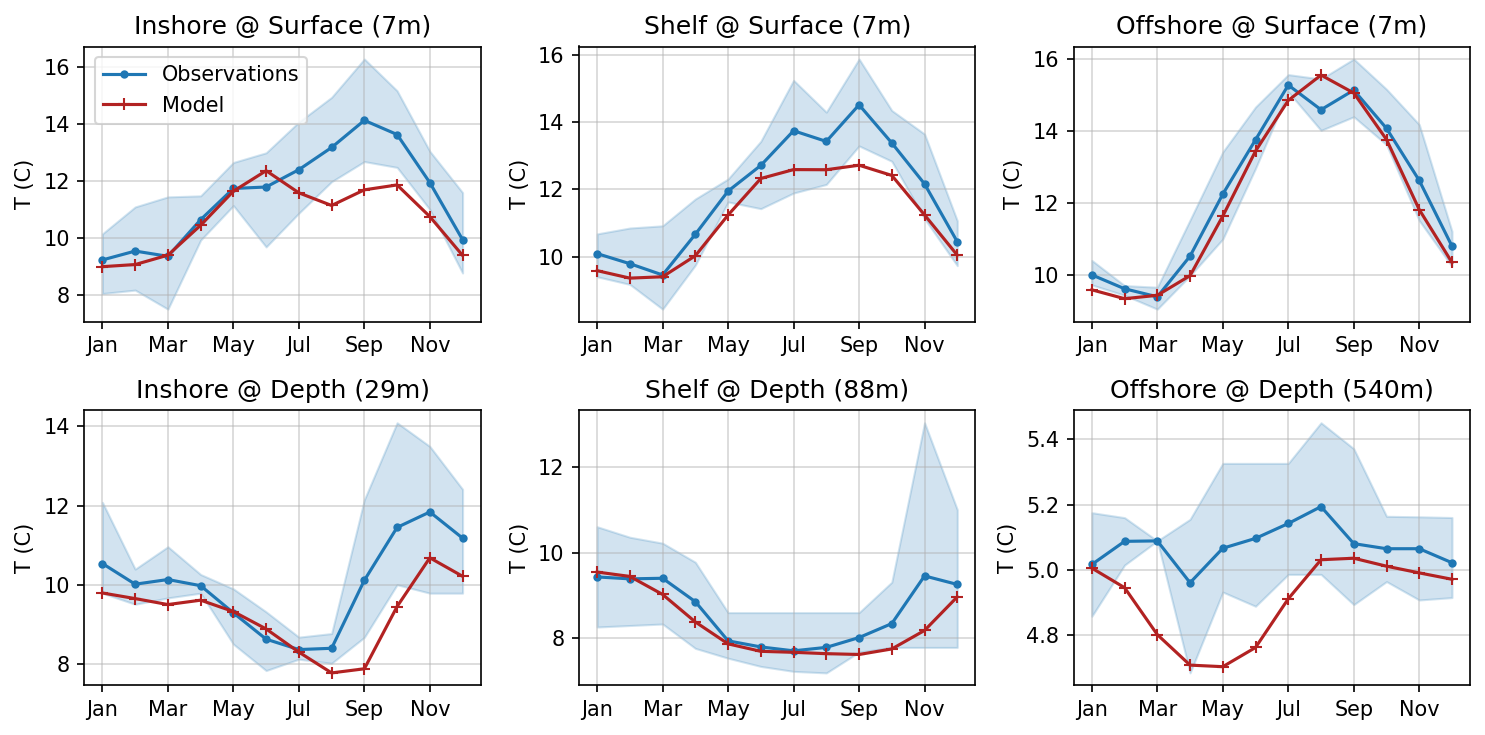

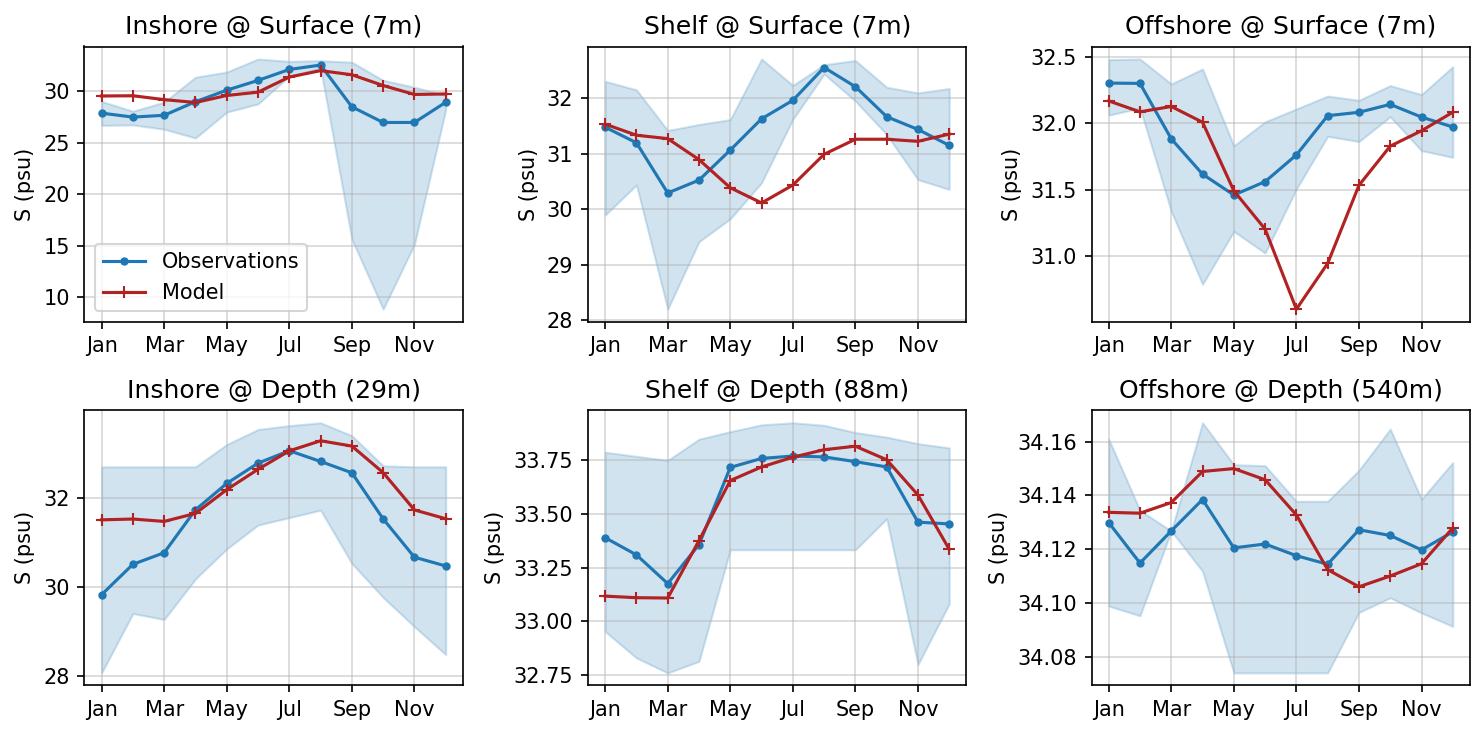

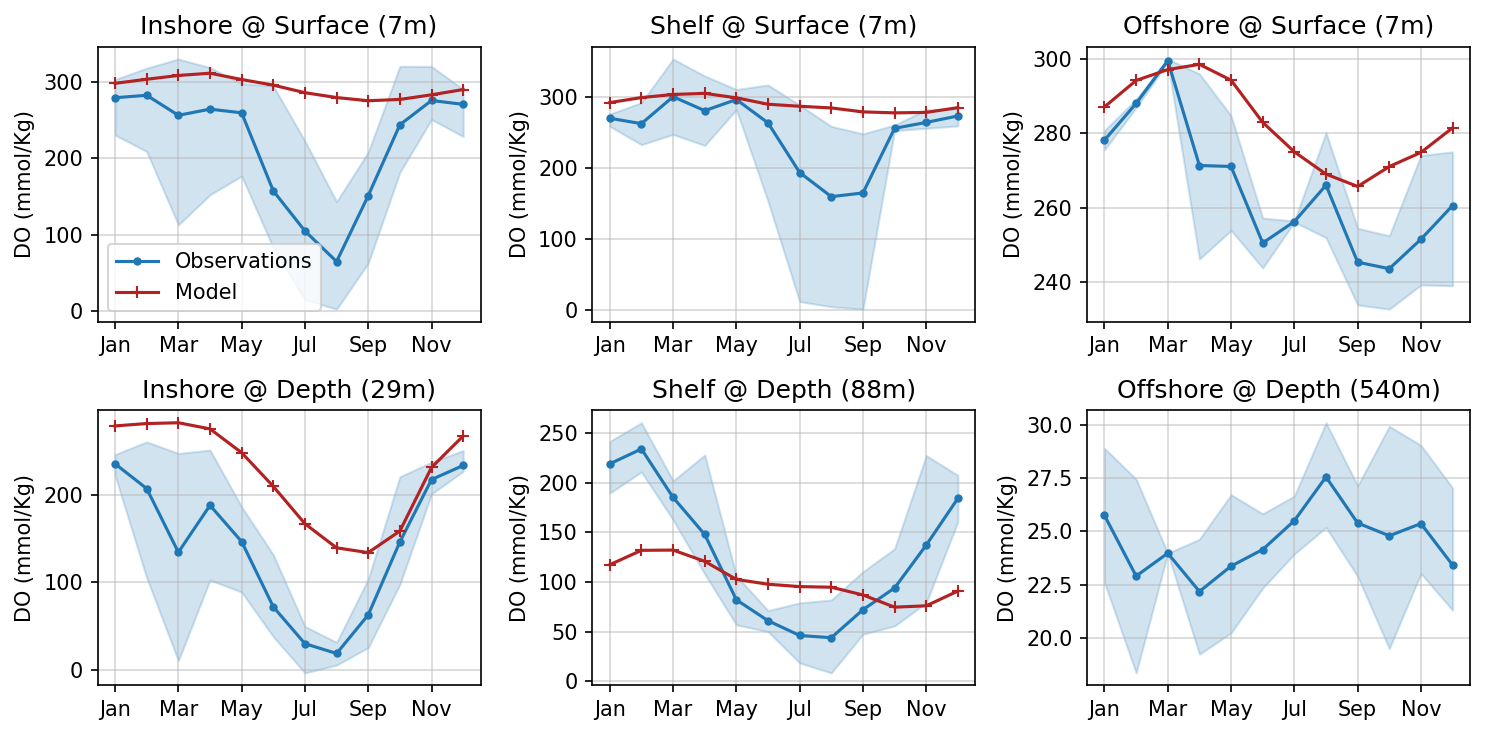

In [20]:
# ooi_clim = [(3,2,3,12,3)] # 3 sites, 2 depth [surf,bottom], 3 variables [T,S,DO], 12 months, [mean, max, min]
# mod_ooi_clim =[(3,2,3,12)] # 3 sites, 2 depth [surf,bottom], 3 variables [T,S,DO], 12 months

# compare 
for i in range(3): # variables
    if i==0: #T
        var='T (C)'
        var2='T'
    elif i==1: # sal
        var='S (psu)'
        var2='S'
    else: # DO
        var='DO (mmol/Kg)'
        var2='DO'

    plt.figure(figsize=(10,5),dpi=150)
    sbi=1
    for k in range(2):  # depth
        for j in range(len(locs)): # inshore, shelf, offshorex 
            plt.subplot(2,3,sbi)
            plt.plot(range(1,13),ooi_clim[j,k,i,:,0],'.-', c='tab:blue', label='Observations')
            plt.fill_between(range(1,13),ooi_clim[j,k,i,:,1],ooi_clim[j,k,i,:,2],':', color='tab:blue', alpha=0.2)
            plt.plot(range(1,13),mod_ooi_clim[j,k,i,:],'+-',c='firebrick', label='Model')
            plt.grid(alpha=0.5)
            plt.xticks(range(1,13,2),labels=['Jan','Mar','May','Jul','Sep','Nov'])
            plt.ylabel(var)
            if k==0:
                plt.title(locs[j]+' @ Surface (7m)')
            else:
                plt.title(locs[j]+' @ Depth ('+str(int(ooi_co[j,2]))+'m)')
            
            if sbi==1:
                plt.legend(loc=0)
            
            sbi += 1
    
    plt.tight_layout()
    plt.savefig(figdir+var2+'_clim_modelvsObs_OOI.png')
    plt.show()

In [21]:
# select model data from WOA observations

T_surf_mod2 = np.full((12,3),0.) # in, shelf, off
T_dept_mod2 = np.full((12,3),0.)

S_surf_mod2 = np.full((12,4),0.) # in, shelf, off
S_dept_mod2 = np.full((12,4),0.)

DO_surf_mod2 = np.full((12,2),0.) # in, shelf, off
DO_dept_mod2 = np.full((12,2),0.)


# select comparable points

for i in range(12):
    # Temperature # surface
    tmp = dtem.thetao.sel(time=i+1,depth=slice(0,5),lat=slice(WOA_T1[0]-0.2,WOA_T1[0]+0.2), lon=slice(WOA_T1[1]-0.2,WOA_T1[1]+0.2))
    T_surf_mod2[i,0] = np.nanmean(tmp)
    tmp = dtem.thetao.sel(time=i+1,depth=slice(0,5),lat=slice(WOA_T2[0]-0.2,WOA_T2[0]+0.2), lon=slice(WOA_T2[1]-0.2,WOA_T2[1]+0.2))
    T_surf_mod2[i,1] = np.nanmean(tmp)
    tmp = dtem.thetao.sel(time=i+1,depth=slice(0,5),lat=slice(WOA_T3[0]-0.2,WOA_T3[0]+0.2), lon=slice(WOA_T3[1]-0.2,WOA_T3[1]+0.2))
    T_surf_mod2[i,2] = np.nanmean(tmp)
    # depth
    tmp = dtem.thetao.sel(time=i+1,depth=slice(WOA_T1[2]-10,WOA_T1[2]+10),lat=slice(WOA_T1[0]-0.2,WOA_T1[0]+0.2), lon=slice(WOA_T1[1]-0.2,WOA_T1[1]+0.2))
    T_dept_mod2[i,0] = np.nanmean(tmp)
    tmp = dtem.thetao.sel(time=i+1,depth=slice(WOA_T2[2]-10,WOA_T2[2]+10),lat=slice(WOA_T2[0]-0.2,WOA_T2[0]+0.2), lon=slice(WOA_T2[1]-0.2,WOA_T2[1]+0.2))
    T_dept_mod2[i,1] = np.nanmean(tmp)
    tmp = dtem.thetao.sel(time=i+1,depth=slice(WOA_T3[2]-10,WOA_T3[2]+10),lat=slice(WOA_T3[0]-0.2,WOA_T3[0]+0.2), lon=slice(WOA_T3[1]-0.2,WOA_T3[1]+0.2))
    T_dept_mod2[i,2] = np.nanmean(tmp)
    
    # salinity
    tmp = dsal.so.sel(time=i+1,depth=slice(0,5),lat=slice(WOA_S1[0]-0.2,WOA_S1[0]+0.2), lon=slice(WOA_S1[1]-0.2,WOA_S1[1]+0.2))
    S_surf_mod2[i,0] = np.nanmean(tmp)
    tmp = dsal.so.sel(time=i+1,depth=slice(0,5),lat=slice(WOA_S2[0]-0.2,WOA_S2[0]+0.2), lon=slice(WOA_S2[1]-0.2,WOA_S2[1]+0.2))
    S_surf_mod2[i,1] = np.nanmean(tmp)
    tmp = dsal.so.sel(time=i+1,depth=slice(0,5),lat=slice(WOA_S3[0]-0.2,WOA_S3[0]+0.2), lon=slice(WOA_S3[1]-0.2,WOA_S3[1]+0.2))
    S_surf_mod2[i,2] = np.nanmean(tmp)
    tmp = dsal.so.sel(time=i+1,depth=slice(0,5),lat=slice(WOA_S4[0]-0.2,WOA_S4[0]+0.2), lon=slice(WOA_S4[1]-0.2,WOA_S4[1]+0.2))
    S_surf_mod2[i,3] = np.nanmean(tmp)
    
    tmp = dsal.so.sel(time=i+1,depth=slice(WOA_S1[2]-10,WOA_S1[2]+10),lat=slice(WOA_S1[0]-0.2,WOA_S1[0]+0.2), lon=slice(WOA_S1[1]-0.2,WOA_S1[1]+0.2))
    S_dept_mod2[i,0] = np.nanmean(tmp)
    tmp = dsal.so.sel(time=i+1,depth=slice(WOA_S2[2]-10,WOA_S2[2]+10),lat=slice(WOA_S2[0]-0.2,WOA_S2[0]+0.2), lon=slice(WOA_S2[1]-0.2,WOA_S2[1]+0.2))
    S_dept_mod2[i,1] = np.nanmean(tmp)
    tmp = dsal.so.sel(time=i+1,depth=slice(WOA_S3[2]-10,WOA_S3[2]+10),lat=slice(WOA_S3[0]-0.2,WOA_S3[0]+0.2), lon=slice(WOA_S3[1]-0.2,WOA_S3[1]+0.2))
    S_dept_mod2[i,2] = np.nanmean(tmp)
    tmp = dsal.so.sel(time=i+1,depth=slice(WOA_S4[2]-10,WOA_S4[2]+10),lat=slice(WOA_S4[0]-0.2,WOA_S4[0]+0.2), lon=slice(WOA_S4[1]-0.2,WOA_S4[1]+0.2))
    S_dept_mod2[i,3] = np.nanmean(tmp)
    
    # dissolved oxygen
    tmp = dox.o2.sel(time=i+1,depth=slice(0,5),lat=slice(WOA_O1[0]-0.2,WOA_O1[0]+0.2), lon=slice(WOA_O1[1]-0.2,WOA_O1[1]+0.2))
    DO_surf_mod2[i,0] = np.nanmean(tmp)
    tmp = dox.o2.sel(time=i+1,depth=slice(0,5),lat=slice(WOA_O2[0]-0.2,WOA_O2[0]+0.2), lon=slice(WOA_O2[1]-0.2,WOA_O2[1]+0.2))
    DO_surf_mod2[i,1] = np.nanmean(tmp)
    
    tmp = dox.o2.sel(time=i+1,depth=slice(WOA_O1[2]-10,WOA_O1[2]+10),lat=slice(WOA_O1[0]-0.2,WOA_O1[0]+0.2), lon=slice(WOA_O1[1]-0.2,WOA_O1[1]+0.2))
    DO_dept_mod2[i,0] = np.nanmean(tmp)
    tmp = dox.o2.sel(time=i+1,depth=slice(WOA_O2[2]-5,WOA_O2[2]+5),lat=slice(WOA_O2[0]-0.2,WOA_O2[0]+0.2), lon=slice(WOA_O2[1]-0.2,WOA_O2[1]+0.2))
    DO_dept_mod2[i,1] = np.nanmean(tmp)
    

print(DO_dept_mod2)

[[ 83.20679614 280.46801536]
 [ 91.57263954 281.38217921]
 [ 89.47962437 280.94943423]
 [ 82.77375416 271.50410743]
 [ 80.12488577 240.72053632]
 [ 81.71029675 204.55306204]
 [ 82.72864925 173.70085893]
 [ 78.29879743 156.18961608]
 [ 67.27536032 152.85043451]
 [ 59.63463213 169.58573581]
 [ 60.70773703 233.11671493]
 [ 67.55512551 267.71268588]]


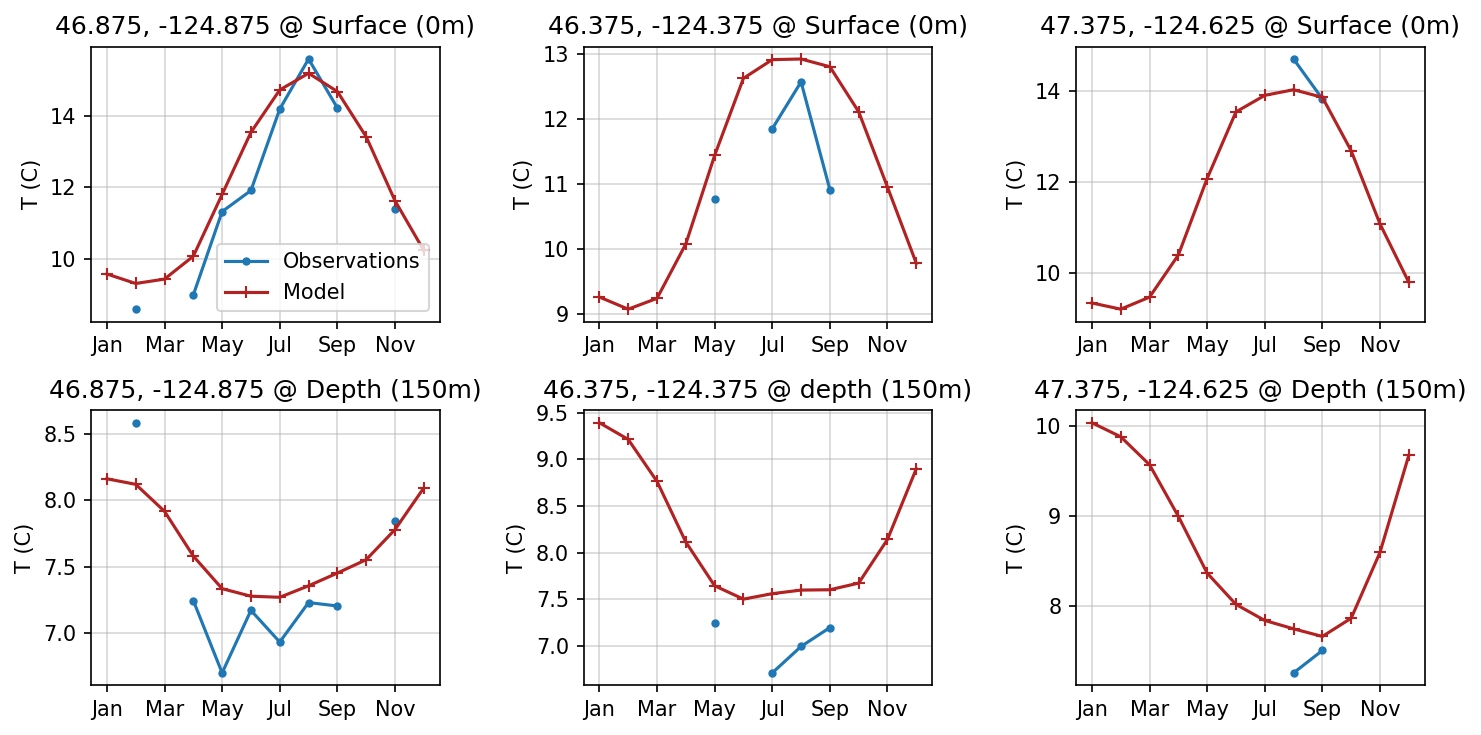

In [22]:
# compare temperature

fil = list(woa)

plt.figure(figsize=(10,5),dpi=150)
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.plot(range(1,13),woa[fil[5+i*2]],'.-', label='Observations')
    plt.plot(range(1,13),T_surf_mod2[:,i],'+-',c='firebrick', label='Model')
    plt.grid(alpha=0.5)
    plt.xticks(range(1,13,2),labels=['Jan','Mar','May','Jul','Sep','Nov'])
    plt.ylabel('T (C)')
    if i==0:
        plt.title(str(WOA_T1[0])+', '+str(WOA_T1[1])+' @ Surface (0m)')
    elif i==2:
        plt.title(str(WOA_T2[0])+', '+str(WOA_T2[1])+' @ Surface (0m)')
    else:
        plt.title(str(WOA_T3[0])+', '+str(WOA_T3[1])+' @ Surface (0m)')
    
    if i==0:
        plt.legend()
        
    plt.subplot(2,3,i+4)
    plt.plot(range(1,13),woa[fil[6+i*2]],'.-')
    plt.plot(range(1,13),T_dept_mod2[:,i],'+-',c='firebrick')
    plt.grid(alpha=0.5)
    plt.xticks(range(1,13,2),labels=['Jan','Mar','May','Jul','Sep','Nov'])
    plt.ylabel('T (C)')
    if i==0:
        plt.title(str(WOA_T1[0])+', '+str(WOA_T1[1])+' @ Depth ('+str(WOA_T1[2])+'m)')
    elif i==2:
        plt.title(str(WOA_T2[0])+', '+str(WOA_T2[1])+' @ Depth ('+str(WOA_T1[2])+'m)')
    else:
        plt.title(str(WOA_T3[0])+', '+str(WOA_T3[1])+' @ depth ('+str(WOA_T1[2])+'m)')
    
plt.tight_layout()
plt.savefig(figdir+'Tclim_modelvsObs_WOA.png')

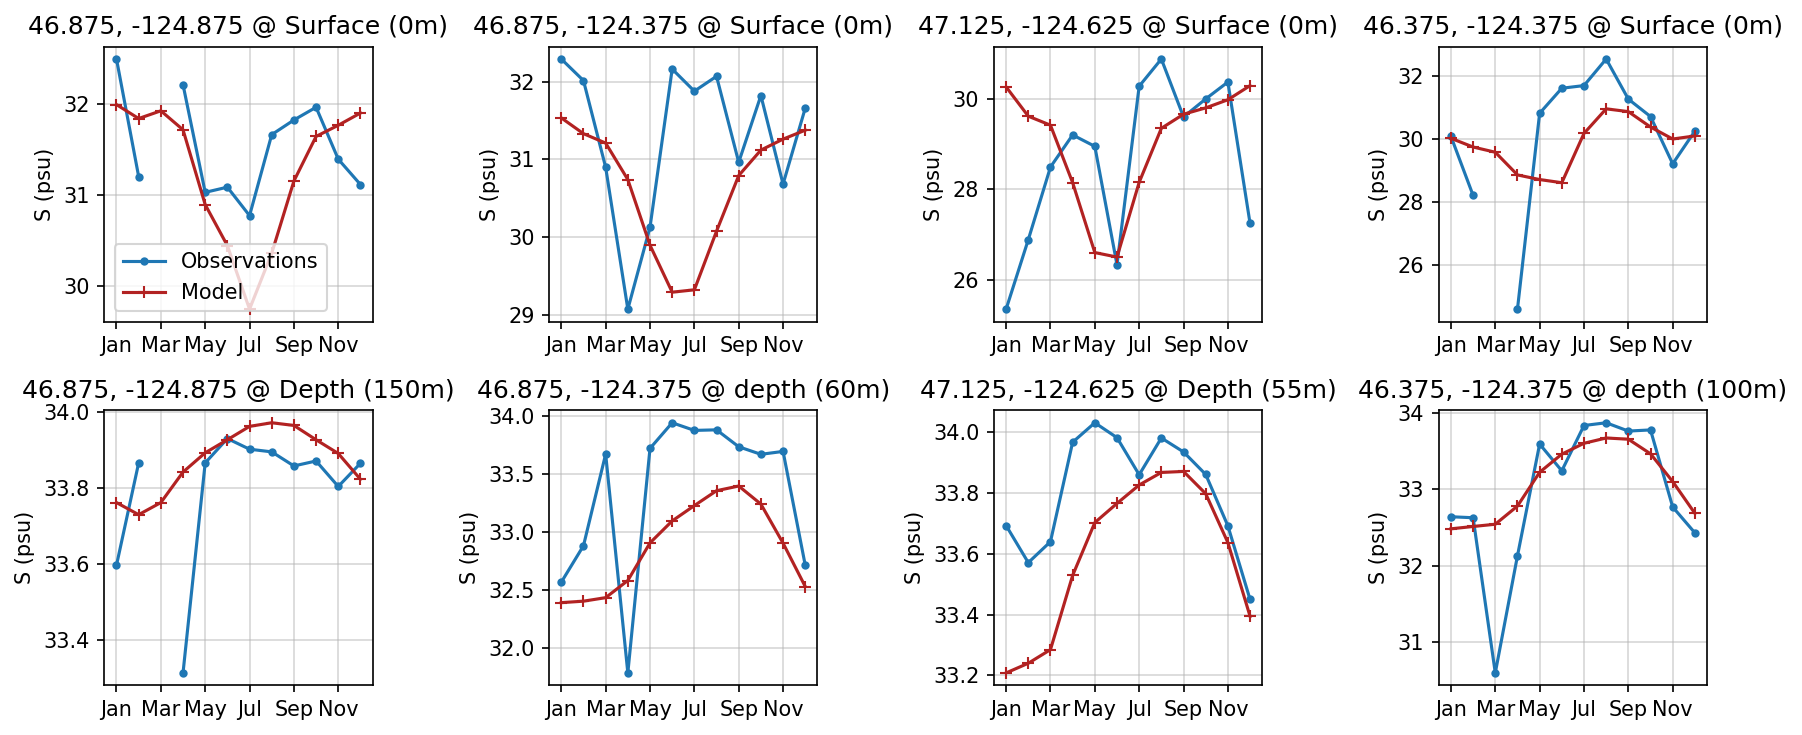

In [23]:
# compare salinity

fil = list(woa)

plt.figure(figsize=(12,5),dpi=150)
for i in range(4):
    plt.subplot(2,4,i+1)
    plt.plot(range(1,13),woa[fil[11+i*2]],'.-', label='Observations')
    plt.plot(range(1,13),S_surf_mod2[:,i],'+-',c='firebrick', label='Model')
    plt.grid(alpha=0.5)
    plt.xticks(range(1,13,2),labels=['Jan','Mar','May','Jul','Sep','Nov'])
    plt.ylabel('S (psu)')
    if i==0:
        plt.title(str(WOA_S1[0])+', '+str(WOA_S1[1])+' @ Surface (0m)')
    elif i==2:
        plt.title(str(WOA_S2[0])+', '+str(WOA_S2[1])+' @ Surface (0m)')
    elif i==3:
        plt.title(str(WOA_S3[0])+', '+str(WOA_S3[1])+' @ Surface (0m)')
    else:
        plt.title(str(WOA_S4[0])+', '+str(WOA_S4[1])+' @ Surface (0m)')
    
    if i==0:
        plt.legend()
        
    plt.subplot(2,4,i+5)
    plt.plot(range(1,13),woa[fil[12+i*2]],'.-')
    plt.plot(range(1,13),S_dept_mod2[:,i],'+-',c='firebrick')
    plt.grid(alpha=0.5)
    plt.xticks(range(1,13,2),labels=['Jan','Mar','May','Jul','Sep','Nov'])
    plt.ylabel('S (psu)')
    if i==0:
        plt.title(str(WOA_S1[0])+', '+str(WOA_S1[1])+' @ Depth ('+str(WOA_S1[2])+'m)')
    elif i==2:
        plt.title(str(WOA_S2[0])+', '+str(WOA_S2[1])+' @ Depth ('+str(WOA_S2[2])+'m)')
    elif i==3:
        plt.title(str(WOA_S3[0])+', '+str(WOA_S3[1])+' @ depth ('+str(WOA_S3[2])+'m)')
    else:
        plt.title(str(WOA_S4[0])+', '+str(WOA_S4[1])+' @ depth ('+str(WOA_S4[2])+'m)')
    
plt.tight_layout()
plt.savefig(figdir+'Sclim_modelvsObs_WOA.png')

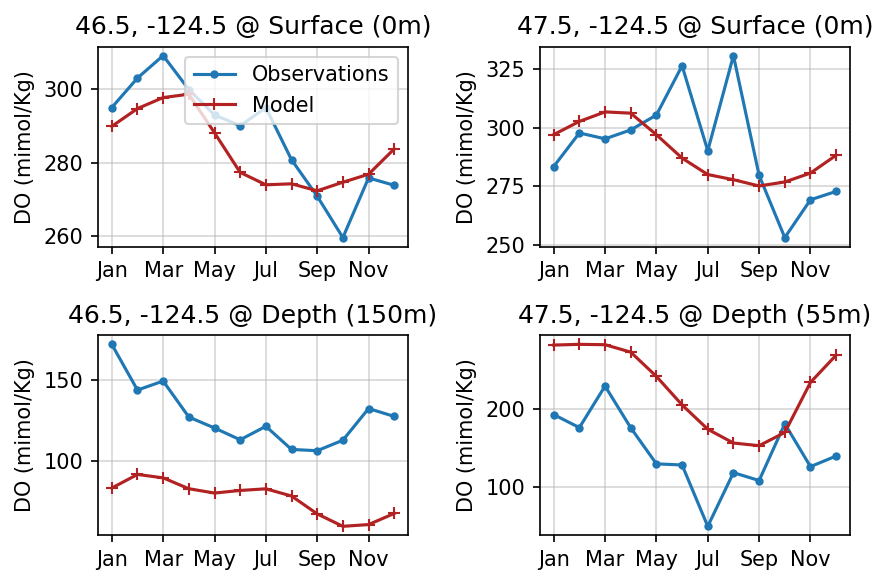

In [24]:
# compare DO

fil = list(woa)

plt.figure(figsize=(6,4),dpi=150)
for i in range(2):
    plt.subplot(2,2,i+1)
    plt.plot(range(1,13),woa[fil[1+i*2]],'.-', label='Observations')
    plt.plot(range(1,13),DO_surf_mod2[:,i],'+-',c='firebrick', label='Model')
    plt.grid(alpha=0.5)
    plt.xticks(range(1,13,2),labels=['Jan','Mar','May','Jul','Sep','Nov'])
    plt.ylabel('DO (mimol/Kg)')
    if i==0:
        plt.title(str(WOA_O1[0])+', '+str(WOA_O1[1])+' @ Surface (0m)')
    elif i==1:
        plt.title(str(WOA_O2[0])+', '+str(WOA_O2[1])+' @ Surface (0m)')
    
    if i==0:
        plt.legend()
        
    plt.subplot(2,2,i+3)
    plt.plot(range(1,13),woa[fil[2+i*2]],'.-')
    plt.plot(range(1,13),DO_dept_mod2[:,i],'+-',c='firebrick')
    plt.grid(alpha=0.5)
    plt.xticks(range(1,13,2),labels=['Jan','Mar','May','Jul','Sep','Nov'])
    plt.ylabel('DO (mimol/Kg)')
    if i==0:
        plt.title(str(WOA_O1[0])+', '+str(WOA_O1[1])+' @ Depth ('+str(WOA_S1[2])+'m)')
    elif i==1:
        plt.title(str(WOA_O2[0])+', '+str(WOA_O2[1])+' @ Depth ('+str(WOA_S2[2])+'m)')
    
plt.tight_layout()
plt.savefig(figdir+'DOclim_modelvsObs_WOA.png')

In [25]:
ldom = np.array([[45, 49],[-126, -123]])
qbox = np.array([[-124.05,-124.33,-125.07,-124.774,-124.05],[46.53,47.4,47.4,46.53,46.53]])

#qbox = np.array([[-124.5,-124,-124.3,-124.8,-124.5],[46.5,46.5,47.5,47.5,46.5]])
#get bathymetry from ETOPO1
fname_topo = '~/Documents/LargeData/Etopo/ETOPO1_Ice_g_gmt4.grd'
ds_topo = xr.open_dataset(fname_topo)
ds_topo.close()
topo = ds_topo.z  #(10801, 21601)
topo2=topo.sel(y=slice(ldom[0,0],ldom[0,1]),x=slice(ldom[1,0],ldom[1,1]))
x = topo2.x  #21601
y = topo2.y   #10801
X,Y=np.meshgrid(x,y)

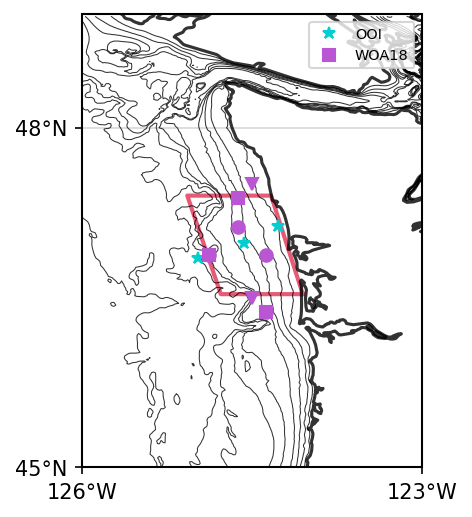

In [26]:
# new box
qbox = np.array([[-124.05,-124.33,-125.07,-124.774,-124.05],[46.53,47.4,47.4,46.53,46.53]])

fig=plt.figure(figsize=(3.2,4),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m',linewidth=1.5,color='black',alpha=0.8,zorder=4)
ax.set_extent([ldom[1,0],ldom[1,1],ldom[0,0],ldom[0,1]],crs=ccrs.PlateCarree())
ax.set_xticks([*range(ldom[1,0],ldom[1,1]+1,3)], crs=ccrs.PlateCarree())
ax.set_yticks([*range(ldom[0,0],ldom[0,1]+1,3)], crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
plt.grid(True, zorder=0,alpha=0.5)
#ax.set_aspect(1.5)
plt.contour(X,Y,topo2,[-2000,-1000,-500,-200,-150, -100,-75, -50,-25],colors='k',linewidths=0.5, linestyles='solid', zorder=3, alpha=0.8)
plt.plot(qbox[0,:],qbox[1,:],c='crimson',lw=2,zorder=2, alpha=0.7)
plt.plot(ooi_co[0,1],ooi_co[0,0],'*',c='darkturquoise',zorder=3, label='OOI')
plt.plot(ooi_co[1,1],ooi_co[1,0],'*',c='darkturquoise',zorder=3)
plt.plot(ooi_co[2,1],ooi_co[2,0],'*',c='darkturquoise',zorder=3)

plt.plot(WOA_T1[1],WOA_T1[0],'s',c='mediumorchid',zorder=3, label='WOA18')
plt.plot(WOA_T2[1],WOA_T2[0],'s',c='mediumorchid',zorder=3)
plt.plot(WOA_T3[1],WOA_T3[0],'s',c='mediumorchid',zorder=3)
plt.plot(WOA_S1[1],WOA_S1[0],'o',c='mediumorchid',zorder=3)
plt.plot(WOA_S2[1],WOA_S2[0],'o',c='mediumorchid',zorder=3)
plt.plot(WOA_S3[1],WOA_S3[0],'o',c='mediumorchid',zorder=3)
plt.plot(WOA_S4[1],WOA_S4[0],'o',c='mediumorchid',zorder=3)
plt.plot(WOA_O1[1],WOA_O1[0],'v',c='mediumorchid',zorder=3)
plt.plot(WOA_O2[1],WOA_O2[0],'v',c='mediumorchid',zorder=3)
plt.legend(loc=0, fontsize='x-small')
fig.savefig(figdir+'map_base_OIIstations.png')
plt.show()